In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt
from moge.network.omics_distance import *


# Import the TCGA cancer data

In [2]:
import pickle
with open('moge/data/luad_data_longest.pickle', 'rb') as file:
    luad_data = pickle.load(file)

In [2]:
folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Unmatched lncRNAs 12727
Unmatched lncRNAs after gencode: 1033
Unmatched lncRNAs after lncBase: 812
Unmatched lncRNAs after HGNC: 758
Unmatched lncRNAs after lncipedia: 622
PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20157)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR
Processed genes info for  LNC


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:884: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID", how="left")


In [27]:
import pysemsim

go = pysemsim.GraphBased('/home/jonny/PycharmProjects/Bioinformatics_ExternalData/GeneOntology/go.obo')




	=== w e l c o m e   t o   p y s e m s i m ! ===&

	Please go for a tea while preprocessing...


        Looking up ancestors -- finished: : 991kit [00:09, 109kit/s]                                         



	Hurray! Preprocessing is ready!
	You can start to calculate semantic similarities:

	This class calculates a graph based semantic similarity
	as it was described in Alvarez & Yan, J. Bioinform. Comput. Biol.
	9:6 (2011) 681-695.

	To calculate semantic similarity between 2 GO terms:

		>>> go.semSim('GO:0048311', 'GO:0000019', aspect = 'P')

	Above, `go` is a <class pysemsim.GraphBased> instance, and aspect
	the ontology tree by default `P` for `biological_process`, or you
	 might use `C` for `cellular_component` or `F` for `molecular_function`.

	To calculate BMA (best match average) of the semantic similarities
	between 2 sets of GO terms, call like this:

		>>> go.setSemSimBMA(goSet1, goSet2, aspect = 'P')

	Where `goSet1` and `goSet2` are lists of GO terms.

	Don`t forget, PyGO caches the result, causing speedup
	as you do more calculations. So keep the same instance.

	Good luck!



In [45]:
goSet1 = GE.loc["A1BG", "GO Terms"].split("|")
goSet2 = GE.loc["A2M", "GO Terms"].split("|")

In [51]:
go.semSim('GO:0048311', 'GO:0000019', aspect = 'P')

0.3147326002322246

In [52]:
go.setSemSimBMA(goSet1, goSet2, aspect='P')

ValueError: no such vertex: 'GO:0002020'

In [5]:
LNC = luad_data.LNC.get_genes_info()
MIR = luad_data.MIR.get_genes_info()
GE = luad_data.GE.get_genes_info()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['Transcript ID', 'Gene ID', 'Gene description', '3P-seq tags',
       'locus_type', 'location', 'gene_family', 'gene_family_id',
       'Transcript sequence', 'GO Terms', 'Disease association', 'Chromosome',
       'Chromosome arm', 'Chromosome region', 'Transcript length'],
      dtype='object')
Index(['miR family', 'Seed+m8', 'Transcript sequence', 'Family Conservation?',
       'MiRBase Accession', 'MiRBase ID', 'location', 'ensembl_gene_id',
       'Disease association', 'locus_type', 'Transcript length', 'GO Terms',
       'Rfams'],
      dtype='object')
Index(['Gene ID', 'Gene Name', 'HGNC Gene Name', 'Transcript id',
       'Transcript name', 'Transcript type', 'tag', 'Chromosome', 'start',
       'end', 'Strand', 'locus_type', 'Transcript sequence',
       'Disease association', 'GO Terms', 'Rfams'],
      dtype='object')


In [8]:
GE[GE["Transcript sequence"].notnull()]["Transcript sequence"].apply(lambda x: len(x))

symbol
A1BG         5
A1CF        10
A2M         13
A2ML1        9
A4GALT       7
A4GNT        1
AAAS        20
AACS        12
AACSP1       2
AADAC        2
AADACL2      2
AADACL3      2
AADACL4      1
AADAT        8
AAGAB        7
AAK1        13
AAMDC       12
AAMP        10
AANAT        4
AAR2         3
AARD         2
AARS         7
AARS2        2
AARSD1      19
AASDH       10
AASDHPPT     5
AASS         7
AATF         9
AATK        11
ABAT        16
            ..
ZSCAN22      1
ZSCAN23      3
ZSCAN25     10
ZSCAN26      7
ZSCAN29      8
ZSCAN30     12
ZSCAN31     19
ZSCAN32     15
ZSCAN4       2
ZSCAN5A     17
ZSCAN5B      4
ZSCAN9       9
ZSWIM1       2
ZSWIM2       2
ZSWIM3       1
ZSWIM4       3
ZSWIM5       2
ZSWIM6       1
ZSWIM7      18
ZSWIM8      23
ZW10         3
ZWILCH      14
ZWINT        9
ZXDA         1
ZXDB         1
ZXDC         4
ZYG11A       3
ZYG11B       2
ZYX         10
ZZEF1       11
Name: Transcript sequence, Length: 19283, dtype: int64

In [21]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = GE.index
# correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["GE"],
#                                                         node_list=node_list, absolute_corr=True,
#                                                         squareform=False)
affinity = compute_annotation_affinities(GE, node_list=node_list,
                features=["GO Terms", "Disease association"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
#                                          correlation_dist=correlation_dist,
                                        nanmean=True, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


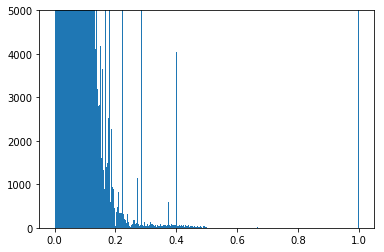

In [22]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [23]:
threshold=0.6
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


threshold at 0.6 : 119652


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


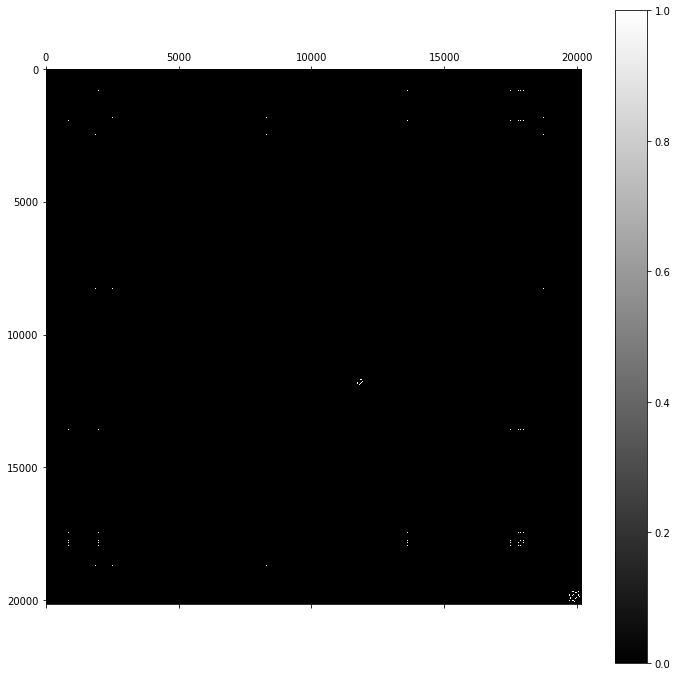

In [24]:
matrix_heatmap(np.array(affinity>threshold, dtype=float))

In [18]:
import wget
for gene in luad_data.LNC.get_genes_list():
    wget.download("http://starbase.sysu.edu.cn/moduleDownload.php?source=rnaRNA&type=xls&value=hg19;"+gene+";1;1", 
              out="/home/jonny/PycharmProjects/Bioinformatics_ExternalData/StarBase v2.0/lncrna_rna_interactions")
    

In [19]:
import os
tables = []
starbase_rna_rna_interaction_folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/StarBase v2.0/lncrna_rna_interactions/"
for filename in os.listdir(starbase_rna_rna_interaction_folder_path):
    if filename.endswith(".xls"):
        table_i = pd.read_table(os.path.join(starbase_rna_rna_interaction_folder_path, filename), comment="#")
        if table_i.loc[0, "geneID"] != 'No Available results.':
            tables.append(table_i)

table = pd.concat(tables, join="inner")
print(table["geneName"].unique().shape)
table

,geneID,geneName,geneType,pairGeneID,pairGeneName,pairGeneType,interactionNum,expNum,seqTypeNum,totalReadsNum,FreeEnergy,AlignScore(Smith-Waterman)
0,ENSG00000237604,AP001056.1,lincRNA,ENSG00000173674,EIF1AX,protein_coding,1,1,1,1,-21.80,19.0
1,ENSG00000237604,AP001056.1,lincRNA,ENSG00000272060.1,RNA18S5,rRNA,1,1,1,2,-26.60,13.5
2,ENSG00000237604,AP001056.1,lincRNA,Entrez100008588,RNA18N5,rRNA,4,1,1,5,-61.90,19.5
0,ENSG00000213468,FIRRE,lincRNA,ENSG00000014641,MDH1,protein_coding,1,1,1,3,-37.90,32.0
1,ENSG00000213468,FIRRE,lincRNA,ENSG00000015479,MATR3,protein_coding,1,1,1,2,-15.90,20.0
2,ENSG00000213468,FIRRE,lincRNA,ENSG00000026559,KCNG1,protein_coding,1,1,1,1,-10.90,14.0
3,ENSG00000213468,FIRRE,lincRNA,ENSG00000083937,CHMP2B,protein_coding,1,1,1,1,-22.30,19.0
4,ENSG00000213468,FIRRE,lincRNA,ENSG00000089597,GANAB,protein_coding,1,1,1,1,-31.00,23.5
5,ENSG00000213468,FIRRE,lincRNA,ENSG00000100426,ZBED4,protein_coding,1,1,1,1,-21.10,20.0
6,ENSG00000213468,FIRRE,lincRNA,ENSG00000104687,GSR,protein_coding,1,1,1,1,-11.80,11.5


In [20]:
# table.to_csv("/home/jonny/PycharmProjects/Bioinformatics_ExternalData/StarBase v2.0/starbase_3.0_lncrna_rna_interactions.csv")

# Heterogeneous Network

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [7]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


59821 undirected positive edges (type='u') added.
299105 undirected negative edges (type='u_n') added.


In [8]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=False,
                                        features=["locus_type", "gene_family_id"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


281421 undirected positive edges (type='u') added.
1407105 undirected negative edges (type='u_n') added.


In [9]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


701 undirected positive edges (type='u') added.
3505 undirected negative edges (type='u_n') added.


In [11]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["Family", "Rfams"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing Family , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Rfams , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


683 undirected positive edges (type='u') added.
3415 undirected negative edges (type='u_n') added.


In [13]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.3,
                                        negative_sampling_ratio=5.0, 
                                        nanmean=False,
                                        features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
                                        weights=[1, 1, 1, 0.5, 0.5, 5],
                                        compute_correlation=True)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Transcript type , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing tag , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Correlation distance (80714865,)
13759 undirected positive edges (type='u') added.
68795 undirected negative edges (type='u_n') added.


In [14]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Family", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Family , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (12706,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


463 undirected positive edges (type='u') added.
2315 undirected negative edges (type='u_n') added.


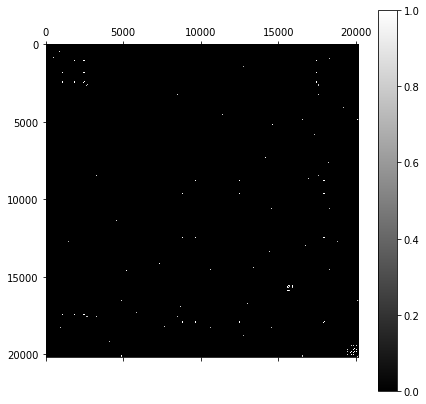

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

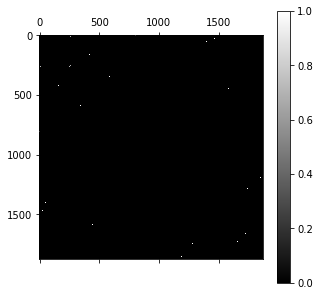

In [8]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

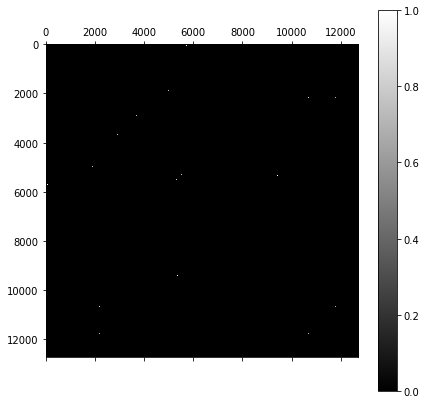

In [9]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [10]:
network.G.number_of_edges()

2131285

In [6]:
network.G.add_edges_from(nx.read_edgelist("moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_NoExpression_affinity.edgelist", 
                                          data=True).edges(data=True))

In [18]:
# WRITE Edgelist
nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
                  data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# Add Regulatory Interaction edges

In [11]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRTarBase_miRNA_target_interaction(), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1759 total unique MIR genes (source), but only matching 1618 nodes
Adding edgelist with 15064 total unique GE genes (target), but only matching 14659 nodes
377318 edges added.


In [12]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_starBase_RNA_RNA_interactions(), # unweighted edges
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

Adding edgelist with 12671 total unique GE genes (source), but only matching 12577 nodes
Adding edgelist with 17752 total unique GE genes (target), but only matching 8838 nodes
163999 edges added.


In [4]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
                                         modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
                                        database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="LncReg")

Adding edgelist with 66 total unique LNC genes (source), but only matching 18 nodes
Adding edgelist with 978 total unique MIR genes (target), but only matching 893 nodes
2375 edges added.
Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 6185 total unique LNC genes (target), but only matching 1009 nodes
53926 edges added.
Adding edgelist with 137 total unique LNC genes (source), but only matching 22 nodes
Adding edgelist with 373 total unique GE genes (target), but only matching 172 nodes
554 edges added.


In [10]:
lnc_with_interactions = [node for node, d in network.G.degree(nbunch=network.nodes["LNC"]) if d > 0]

In [11]:
mrna_with_interactions = [node for node, d in network.G.degree(nbunch=network.nodes["GE"]) if d > 0]
len(mrna_with_interactions)

451

In [14]:
nodes_w_seq = network.genes_info[network.genes_info["Transcript sequence"].notnull()].index
lnc_with_interactions = [node for node in lnc_with_interactions if node in nodes_w_seq]
mrna_with_interactions = [node for node in mrna_with_interactions if node in nodes_w_seq]

In [16]:
ofile = open("/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/SequenceFiles/mRNA_ints.fa", "w")
for node in mrna_with_interactions:
    ofile.write(">" + node + "\n" +network.genes_info.loc[node, "Transcript sequence"] + "\n")
ofile.close()

In [50]:
lnc_with_interactions.index("FOXP1-AS1")

518

In [36]:
len(lnc_with_interactions)

796

# Filter the node_list

In [14]:
isolates = list(nx.isolates(network.G))

In [15]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [16]:
# network.remove_extra_nodes() # Also makes network unmutable

In [17]:
network.G.number_of_nodes()

47480

In [18]:
len(network.node_list)

32530

In [20]:
# WRITE FULL network
import pickle
with open('moge/data/LMN_only_directed/full_affinity_interactions/lmn_Affinity_starBase_lncBase_miRTarBase_LncReg_lncRNome_full.pickle', 'wb') as file:
    pickle.dump(network, file)

# Split train-test by edges

In [27]:
import pickle
with open('moge/data/LMN_only_directed/full_affinity_interactions/lmn_Affinity_starBase_lncBase_miRTarBase_LncReg_lncRNome_full.pickle', 'rb') as file:
    network = pickle.load(file)

In [21]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345896
edges_to_remove (after MST) 345742
test_edges_size 0
val_edges_size 69148
Removed 0 test, and 69148 val, type ['d'] edges


In [22]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [18]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
removed 135945 edges, and  1129 nodes.
validation edges 59775
test edges 0


In [21]:
val_nodes

['hsa-mir-6125',
 'hsa-mir-432',
 'hsa-mir-296',
 'hsa-mir-4509-1',
 'hsa-mir-5094',
 'hsa-mir-411',
 'hsa-mir-545',
 'hsa-mir-527',
 'hsa-mir-4513',
 'hsa-mir-218-2',
 'hsa-mir-298',
 'hsa-mir-4447',
 'hsa-mir-4435-1',
 'hsa-mir-3941',
 'hsa-mir-4306',
 'hsa-mir-7853',
 'hsa-mir-6727',
 'hsa-mir-362',
 'hsa-mir-587',
 'hsa-mir-891a',
 'hsa-mir-662',
 'hsa-mir-3199-1',
 'hsa-mir-4728',
 'hsa-mir-645',
 'hsa-mir-6767',
 'hsa-mir-5092',
 'hsa-mir-551a',
 'hsa-mir-876',
 'hsa-mir-2861',
 'hsa-mir-4747',
 'hsa-mir-26b',
 'hsa-mir-1538',
 'hsa-mir-4311',
 'hsa-mir-618',
 'hsa-mir-1256',
 'hsa-mir-3907',
 'hsa-mir-599',
 'hsa-mir-6859-1',
 'hsa-mir-34a',
 'hsa-mir-495',
 'hsa-mir-3660',
 'hsa-mir-3619',
 'hsa-mir-548v',
 'hsa-mir-550b-1',
 'hsa-mir-3119-1',
 'hsa-mir-548h-1',
 'hsa-mir-4280',
 'hsa-mir-5692c-1',
 'hsa-mir-4653',
 'hsa-mir-5699',
 'hsa-mir-33b',
 'hsa-mir-181c',
 'hsa-mir-3662',
 'hsa-mir-3648',
 'hsa-mir-26a-1',
 'hsa-mir-4680',
 'hsa-mir-4515',
 'hsa-mir-200a',
 'hsa-mir-67

In [19]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

MIR  nodes: 1870
GE  nodes: 20163
LNC  nodes: 12644
Total nodes: 34677
Genes info columns: ['locus_type', 'Family', 'Transcript sequence', 'Disease association']
Number of nodes without seq removed: 2145
Total nodes (filtered): 32533
MIR  nodes: 1870
GE  nodes: 20163
LNC  nodes: 12644
Total nodes: 34677
Genes info columns: ['locus_type', 'Family', 'Transcript sequence', 'Disease association']
Number of nodes without seq removed: 2145
Total nodes (filtered): 32533


(32532, 32532)

In [23]:
network_train.G.number_of_edges()

2658999

# Write train-test-val split as separate networks

In [24]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges10/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges10/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges10/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [25]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges10/lmn_edges20_train.full.edgelist", 
                  data=False)

In [26]:
nx.write_edgelist(nx.Graph(incoming_graph_data=network_train.get_edgelist(edge_types=["d"], node_list=network_train.node_list)),
                  "moge/data/LMN_only_directed/lmn_edges10/lmn_edges20_train.interactions.edgelist",
                  data=False)

In [24]:
# import pickle
# with open('moge/data/LMN_only_directed/lmn_miRTarBase_edges10_train.pickle', 'rb') as file:
#     network = pickle.load(file)

# WRITE Edgelist
nx.write_edgelist(network.get_subgraph(["GE"]), 
                  "moge/data/LMN_only_directed/lmn_starBaseFull_GE_edges50_train.edgelist", 
                  data=False)

## Network Info & Visualizations

In [22]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

33120
1243116


In [23]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

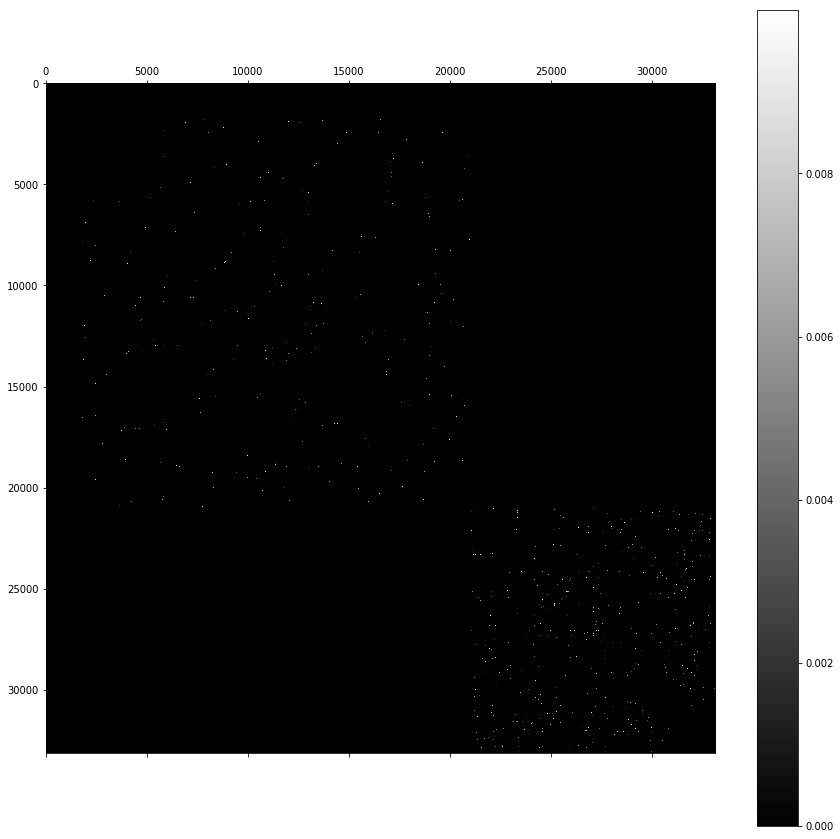

In [24]:
matrix_heatmap(csr_un.toarray())

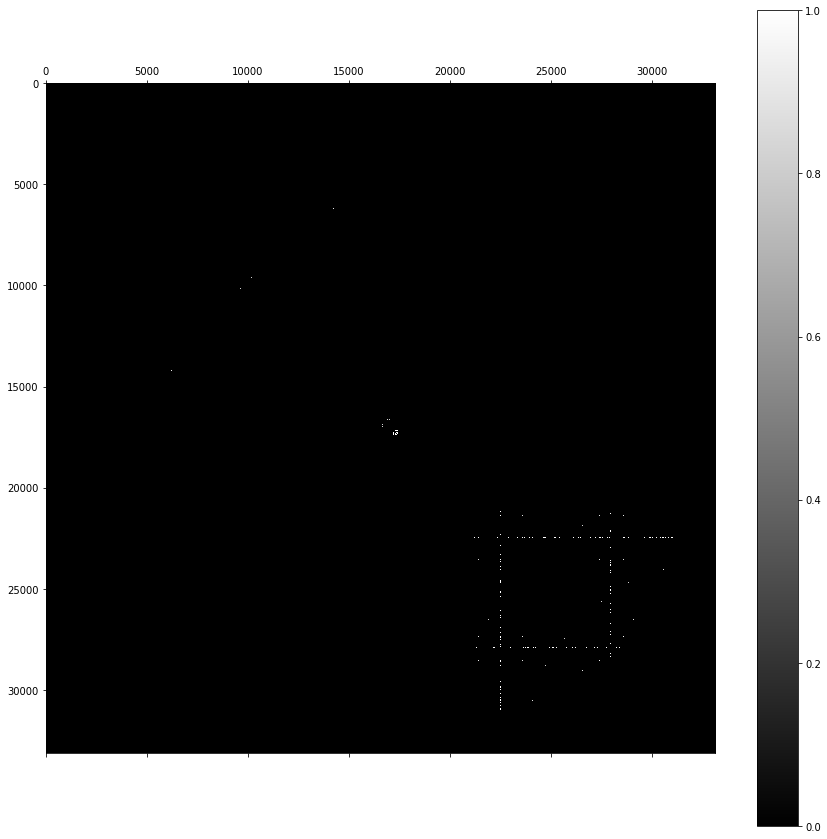

In [25]:
matrix_heatmap(csr_u.toarray())

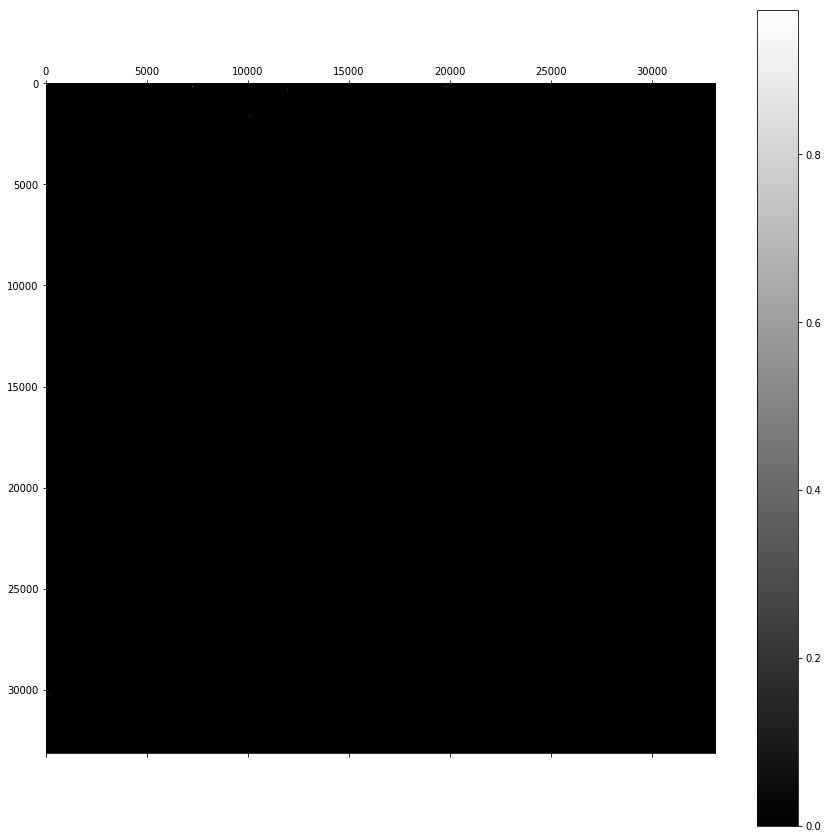

In [26]:
matrix_heatmap(csr_d.toarray())